In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from termcolor import colored
from torch.nn.modules import flatten
from tqdm.notebook import tqdm
from matplotlib import patches
from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, sampler
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CustomVOCDataset(torchvision.datasets.VOCDetection):
    def init_config_yolo(self, class_mapping, S=7, B=2, C=20, custom_transforms=None):
        self.S = S
        self.B = B
        self.C = C
        self.class_mapping = class_mapping
        self.custom_transforms = custom_transforms

    def __getitem__(self, idx):
        image, target = super(CustomVOCDataset, self).__getitem__(idx)
        img_width, img_height = image.size

        boxes = convert_to_yolo_format(target, img_width, img_height, self.class_mapping)

        just_boxes = boxes[:, 1:]
        labels = boxes[:, 0]

        if self.custom_transforms:
            sample = {
                'image': np.array(image),
                'bboxes': just_boxes,
                'labels': labels
            }

            sample = self.custom_transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        image = torch.as_tensor(image, dtype=torch.float32)

        for box, class_label in zip(boxes, labels):
            x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S
            )

            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [3]:
def convert_to_yolo_format(target, img_width, img_height, class_mapping):
    annotations = target['annotation']['object']

    real_width = int(target['annotation']['size']['width'])
    real_height = int(target['annotation']['size']['height'])

    if not isinstance(annotations, list):
        annotations = [annotations]

    boxes = []

    for anno in annotations:
        xmin = int(anno['bndbox']['xmin']) / real_width
        ymin = int(anno['bndbox']['ymin']) / real_height
        xmax = int(anno['bndbox']['xmax']) / real_width
        ymax = int(anno['bndbox']['ymax']) / real_height

        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin

        class_name = anno['name']
        class_id = class_mapping[class_name] if class_name in class_mapping else 0

        boxes.append([class_id, x_center, y_center, width, height])

    return np.array(boxes)

In [4]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box2_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box2_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box2_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_preds[..., 0:1]
        box2_y1 = boxes_preds[..., 1:2]
        box2_x2 = boxes_preds[..., 2:3]
        box2_y2 = boxes_preds[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format='corners'):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]

    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [6]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='midpoint', num_classes=20):
    average_precisions = []

    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format=box_format)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        average_precisions.append(torch.trapz(precisions, recalls))
    return sum(average_precisions) / len(average_precisions)
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda",):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def get_bboxes_training(outputs, labels, iou_threshold=0.5, threshold=0.4, box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    train_idx = 0

    true_bboxes = cellboxes_to_boxes(labels)
    bboxes = cellboxes_to_boxes(outputs)

    for idx in range(outputs.shape[0]):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        for box in true_bboxes[idx]:
            if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)

        train_idx += 1

    return all_pred_boxes, all_true_boxes

def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


In [7]:
architecture_config = [
    (7, 64, 2, 3),
    'M',
    (3, 192, 1, 1),
    'M',
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    'M',
    [(1, 256, 1 ,0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    'M',
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])
                    ]
                    layers += [
                        CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])
                    ]
                    in_channels =  conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5))
        )

In [8]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)

        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )

        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21])
        )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
            torch.flatten(exists_box * target[..., :20], end_dim=-2)
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj + no_object_loss
            + class_loss
        )

        return loss

In [9]:
seed = 123
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
EPOCHS = 10
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = 'yolov1.pth.tar'

In [10]:
WIDTH = 448
HEIGHT = 448

def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
                ],
                p=0.9
            ),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.Resize(height=HEIGHT, width=WIDTH, p=1),
            ToTensorV2(p=1.0)
        ],
        p=1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels'])
    )

def get_val_transforms():
    return A.Compose(
        [
            A.Resize(height=HEIGHT, width=WIDTH, p=1.0),
            ToTensorV2(p=1.0)
        ],
        p=1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels'])
    )

In [11]:
class_mapping = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

In [12]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    mean_loss = []
    mean_mAP = []

    total_batches = len(train_loader)
    display_interval = total_batches // 5

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_boxes, true_boxes = get_bboxes_training(out, y, iou_threshold=0.5, threshold=0.4)
        mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='midpoint')

        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())

        if batch_idx % display_interval == 0 or batch_idx == total_batches - 1:
            print(f'Epoch: {epoch:3} \t Iter: {batch_idx:3}/{total_batches:3} \t Loss: {loss.item():3.10f} \t mAP: {mAP.item():3.10f}')

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)
    print(colored(f'Train \t loss: {avg_loss:3.10f} \t mAP: {avg_mAP:3.10f}', 'green'))

    return avg_mAP

def val_test_fn(data_loader, model, loss_fn, epoch, is_test=False):
    model.eval()
    mean_loss = []
    mean_mAP = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            out = model(x)
            loss = loss_fn(out, y)

            normalized_loss = loss / x.size(0)

            pred_boxes, true_boxes = get_bboxes_training(
                out, y, iou_threshold=0.5, threshold=0.4
            )
            mAP = mean_average_precision(
                pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint"
            )

            mean_loss.append(normalized_loss.item())
            mean_mAP.append(mAP.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)

    if is_test:
        print(
            colored(f"Test \t loss: {avg_loss:.10f} \t mAP: {avg_mAP:.10f}", "yellow")
        )
    else:
        print(colored(f"Val \t loss: {avg_loss:.10f} \t mAP: {avg_mAP:.10f}", "blue"))

    model.train()
    return avg_mAP

In [13]:
def train():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = CustomVOCDataset(
        root='./data',
        year='2012',
        image_set='train',
        download=True
    )

    train_dataset.init_config_yolo(class_mapping=class_mapping, custom_transforms=get_train_transforms())

    testval_dataset = CustomVOCDataset(
        root='./data',
        year='2012',
        image_set='val',
        download=True
    )

    testval_dataset.init_config_yolo(class_mapping=class_mapping, custom_transforms=get_val_transforms())

    dataset_size = len(testval_dataset)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - val_size

    val_indices = list(range(val_size))
    test_indices = list(range(val_size, val_size + test_size))

    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        drop_last=True
    )

    val_loader = DataLoader(
        dataset=testval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=val_sampler,
        drop_last=False
    )

    test_loader = DataLoader(
        dataset=testval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=test_sampler,
        drop_last=False
    )

    best_mAP_train = 0
    best_mAP_val = 0
    best_mAP_test = 0

    for epoch in range(EPOCHS):
        train_mAP = train_fn(train_loader, model, optimizer, loss_fn, epoch)
        val_mAP = val_test_fn(val_loader, model, loss_fn, epoch)
        test_mAP = val_test_fn(test_loader, model, loss_fn, epoch, is_test=True)

        if train_mAP > best_mAP_train:
            best_mAP_train = train_mAP
        if val_mAP > best_mAP_val:
            best_mAP_val =val_mAP
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        if test_mAP > best_mAP_test:
            best_mAP_test = test_mAP

    print(colored(f'Best Train mAP: {best_mAP_train:3.10f}', 'green'))
    print(colored(f'Best Val mAP: {best_mAP_val:3.10f}', 'blue'))
    print(colored(f'Best Test mAP: {best_mAP_test:3.10f}', 'yellow'))

In [14]:
def plot_image_with_labels(image, ground_truth_boxes, predicted_boxes, class_mapping, ax=None):
    inverted_class_mapping = {v: k for k, v in class_mapping.items()}

    im = np.array(image)
    height, width, _ = im.shape

    ax.axis("off")
    ax.imshow(im)

    for box in ground_truth_boxes:
        label_index, box = box[0], box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        ax.add_patch(rect)
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="green", alpha=0.2),
        )

    for box in predicted_boxes:
        label_index, box = box[0], box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="red", alpha=0.2),
        )

    return ax

def test():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

    if LOAD_MODEL:
        model.load_state_dict(torch.load(LOAD_MODEL_FILE)["state_dict"])

    test_dataset = CustomVOCDataset(root="./data", image_set="val", download=False)
    test_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transforms=get_val_transforms()
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)

        pred_bboxes = cellboxes_to_boxes(out)
        gt_bboxes = cellboxes_to_boxes(y)

        fig, axes = plt.subplots(2, 4, figsize=(12, 12))
        axes = axes.flatten()

        for idx in range(8):
            pred_box = non_max_suppression(
                pred_bboxes[idx],
                iou_threshold=0.5,
                threshold=0.4,
                box_format="midpoint",
            )
            gt_box = non_max_suppression(
                gt_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint"
            )

            image = x[idx].permute(1, 2, 0).to("cpu") / 255
            ax_image = plot_image_with_labels(
                image, gt_box, pred_box, class_mapping, ax=axes[idx]
            )

        plt.tight_layout()
        plt.show()

        break

In [15]:
train()

100%|██████████| 2.00G/2.00G [02:07<00:00, 15.7MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch:   0 	 Iter:   0/357 	 Loss: 1317.5754394531 	 mAP: 0.0000000000
Epoch:   0 	 Iter:  71/357 	 Loss: 238.1033477783 	 mAP: 0.0236930884
Epoch:   0 	 Iter: 142/357 	 Loss: 168.2653656006 	 mAP: 0.0363247618
Epoch:   0 	 Iter: 213/357 	 Loss: 181.7257995605 	 mAP: 0.1446492374
Epoch:   0 	 Iter: 284/357 	 Loss: 275.1144714355 	 mAP: 0.0000000000
Epoch:   0 	 Iter: 355/357 	 Loss: 197.8031158447 	 mAP: 0.0000000000
Epoch:   0 	 Iter: 356/357 	 Loss: 229.9155273438 	 mAP: 0.0000000000
Train 	 loss: 252.9990595970 	 mAP: 0.0324987184
Val 	 loss: 14.1485156146 	 mAP: 0.0086090408
Test 	 loss: 14.2680441779 	 mAP: 0.0115366943
=> Saving checkpoint
Epoch:   1 	 Iter:   0/357 	 Loss: 203.7571716309 	 mAP: 0.0000000000
Epoch:   1 	 Iter:  71/357 	 Loss: 196.9958343506 	 mAP: 0.0115274768
Epoch:   1 	 Iter: 142/

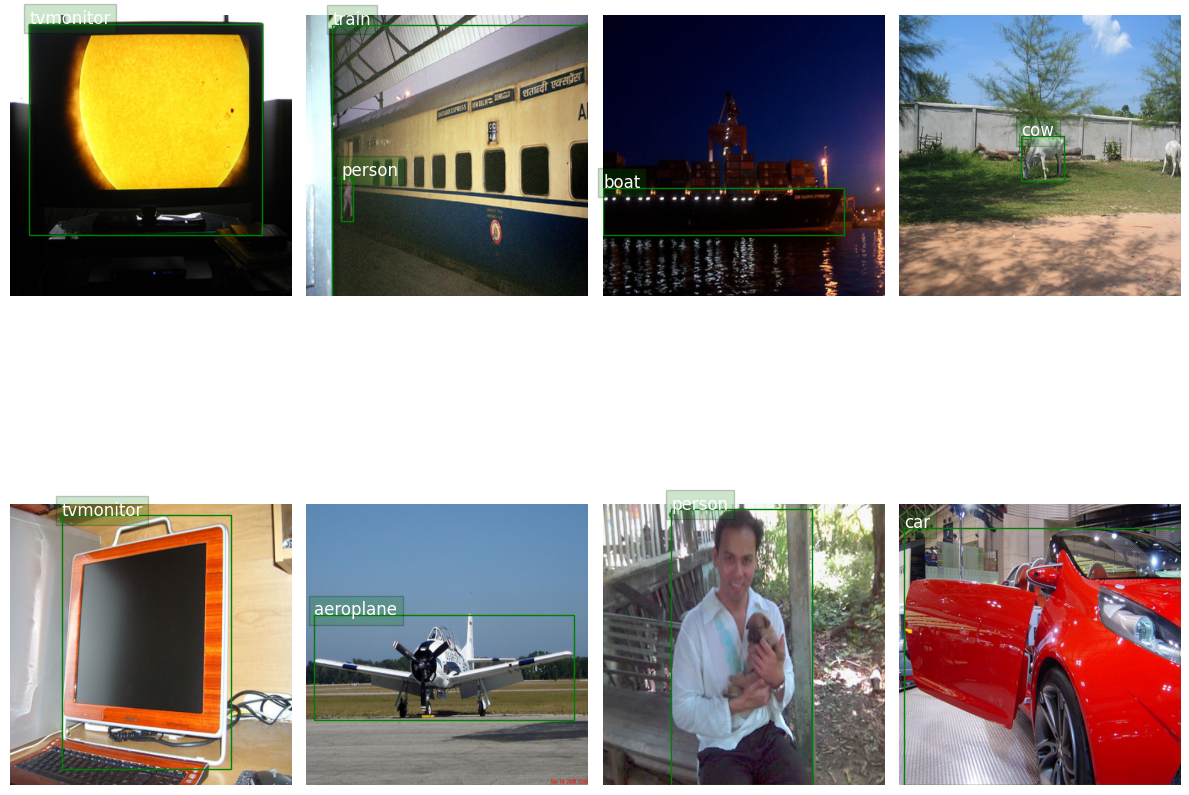

In [16]:
test()